In [22]:
#import libraries
import os
import numpy as np
import pandas as pd
from scipy.spatial import distance
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris

In [23]:
#load data
if not os.path.exists("./data"):
    raise ValueError('You need to import the data first, run load_data.py')
else:
    #df = pd.read_csv('data/iris_data.csv',sep='\t')
    df = pd.read_csv('data/data_titanic.csv',sep='\t')

## Initial exploration

In [24]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [25]:
#report nans
df.isnull().mean()

survived       0.000000
pclass         0.000000
sex            0.000000
age            0.198653
sibsp          0.000000
parch          0.000000
fare           0.000000
embarked       0.002245
class          0.000000
who            0.000000
adult_male     0.000000
deck           0.772166
embark_town    0.002245
alive          0.000000
alone          0.000000
dtype: float64

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


## Supporting functions

In [27]:
## functions for preprocessing

#check for duplicates
def check_duplicates(df):
    has_dup = df.duplicated()
    true_dup = np.where(has_dup == True)
    if len(true_dup[0]) > 0:
        print("Data has", len(true_dup[0]), "duplicates")
    else:
        print("No duplicates found")

#function for one-hot encoding
def one_hot(df, column_names):
    for col in column_names:
        dummies = pd.get_dummies(df[[col]].astype('category'))
        df = pd.concat([df, dummies], axis=1)
        df = df.drop([col], axis=1)
    return df

#function for adding interaction terms
def add_interactions(df,degree=2):
    poly = PolynomialFeatures(interaction_only=True, include_bias=False, degree=degree)
    X_poly = poly.fit_transform(df)
    column_names = list(poly.get_feature_names_out())
    X_poly = pd.DataFrame(X_poly,columns=column_names)
    return X_poly

#function for computing sigmoid (e.g. to look at logistic regression fit)
def sigmoid(x,b):
    return 1 / (1 + np.exp(-(b+x)))

#min-max scale vector to pre-specified range
def linmap(vector, new_min, new_max):
    vector = np.array(vector)
    old_min = np.min(vector)
    old_max = np.max(vector)
    
    # Avoid division by zero if the old_min equals old_max
    if old_min == old_max:
        return np.full_like(vector, new_min if old_min == old_max else new_max)
    
    # Scale the vector
    scaled_vector = (vector - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    return scaled_vector


## Clean the data

In [29]:
target_column = 'survived'
#target_column = 'target'


### main preprocessing function:

## done on train and test set together
#clean up column names
df.columns = [col.replace(' ', '_') for col in df.columns]
df.columns = [col.replace('(',  '') for col in df.columns]
df.columns = [col.replace(')',  '') for col in df.columns]

#drop column names that we don't need
df = df.drop(['embark_town', 'alive', 'deck'],axis=1)

#check and report on duplicate data
check_duplicates(df)

# Checking for data imbalance
df[target_column].value_counts()

#non-linear scaling of values
df['fare'] = df.fare.apply(lambda x: np.log(x) if x > 0 else 0)

#run train-test split
X = df
X_train, X_test, _, _ = train_test_split(X, df[target_column], random_state=1234) #note: X still contains the y-variable in the 'target' column

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)


## done separately for train and test

#imputing
X_train.age = X_train.age.fillna(X_train.age.median())
X_test.age  = X_test.age.fillna(X_test.age.median())

#columns_to_scale = ['sepal_length_cm', 'sepal_width_cm','petal_length_cm','petal_width_cm']
columns_to_scale = df.select_dtypes(include='number').columns.drop(target_column) #identify the numberic columns

#remove outliers from the training set

#range normalization
scaler = MinMaxScaler()
scaler.set_output(transform="pandas")

X_train_scaled = scaler.fit_transform(X_train[columns_to_scale])
X_test_scaled  = scaler.transform(X_test[columns_to_scale])
X_train = pd.concat([X_train_scaled, X_train.drop(columns_to_scale,axis=1)], axis=1)
X_test  = pd.concat([X_test_scaled, X_test.drop(columns_to_scale,axis=1)], axis=1)

#separate the target
y_train = X_train[target_column]
X_train = X_train.drop(target_column,axis=1)
y_test = X_test[target_column]
X_test = X_test.drop(target_column,axis=1)

Data has 111 duplicates


<Axes: >

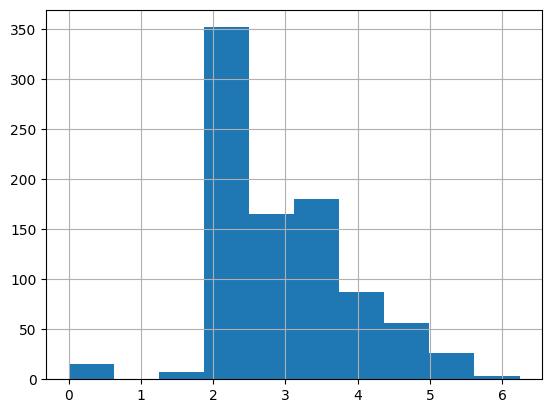

In [30]:
df.fare.hist()

##  Feature engineering

In [ ]:
#one-hot encode categorical variables

#add interaction terms
